In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
from wrangle import wrangle_zillow

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

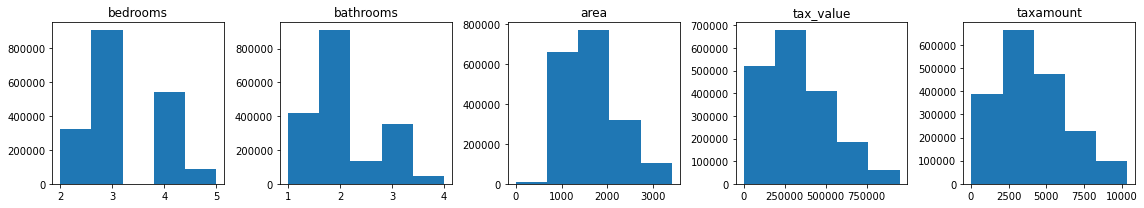

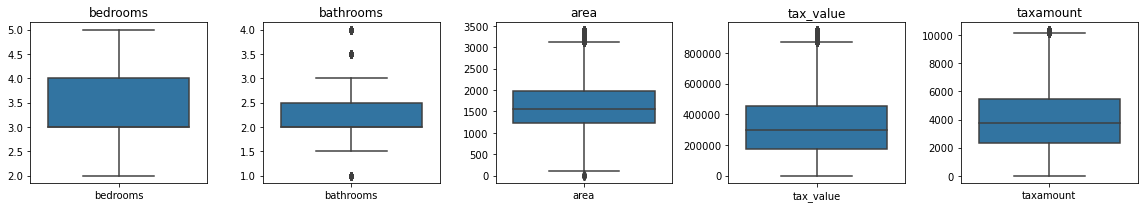

In [2]:
train, validate, test = wrangle_zillow()

In [5]:
train["fips"] = pd.to_numeric(train["fips"])
validate["fips"] = pd.to_numeric(validate["fips"])
test["fips"] = pd.to_numeric(test["fips"])

In [11]:
# drop target column
X_train = train.drop(columns = 'tax_value')
y_train = train.tax_value

X_validate = validate.drop(columns = 'tax_value')
y_validate = validate.tax_value

X_test = test.drop(columns = 'tax_value')
y_test = test.tax_value

In [13]:
# scaling my X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [14]:
X_validate = pd.DataFrame(X_validate)
type(X_validate)

pandas.core.frame.DataFrame

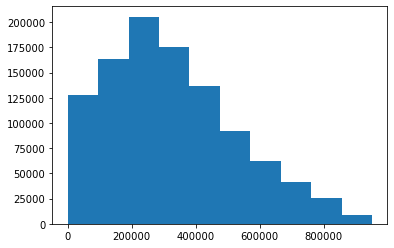

In [15]:
plt.hist(y_train)
plt.show()

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the tax_value without using any features. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


In [16]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [17]:
# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

In [18]:
# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

In [19]:
# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

In [20]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  198987.48 
Validate/Out-of-Sample:  198712.69


In [21]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  201440.18 
Validate/Out-of-Sample:  201109.24


In [22]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [23]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)

In [24]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.0


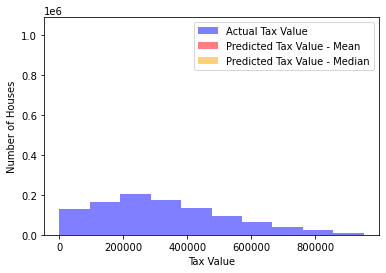

In [25]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Value - Mean")
plt.hist(y_train.tax_value_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Tax Value - Median")
plt.xlabel("Tax Value")
plt.ylabel("Number of Houses")
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [26]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [27]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [28]:
# predict train
# 
# use the thing!
# 
y_train['tax_value_pred_lm'] = lm.predict(X_train)

In [33]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** .5

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  178779.48916691804 
Validation/Out-of-Sample:  178544.46637739244


In [35]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)

In [36]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.000000
1,OLS Regressor,178544.466377,0.192687


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [37]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  178799.4696876477 
Validation/Out-of-Sample:  178544.46637739244


In [38]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [39]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.000000
1,OLS Regressor,178544.466377,0.192687
2,lasso_alpha_1,178566.575214,0.192487


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [40]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  178819.28960084176 
Validation/Out-of-Sample:  178819.28960084176


In [43]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm,
               'glm_poisson',
               metric_df)

In [44]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.000000
1,OLS Regressor,178544.466377,0.192687
2,lasso_alpha_1,178566.575214,0.192487
3,glm_poisson,178603.016654,0.192158


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [49]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [50]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  176804.04673860274 
Validation/Out-of-Sample:  31168728612.59446


In [52]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'quadratic',
               metric_df)

In [60]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.000000
1,OLS Regressor,178544.466377,0.192687
2,lasso_alpha_1,178566.575214,0.192487
3,glm_poisson,178603.016654,0.192158
4,quadratic,176546.675450,0.210652


### Evaluate

**Plotting Actual vs. Predicted Values**

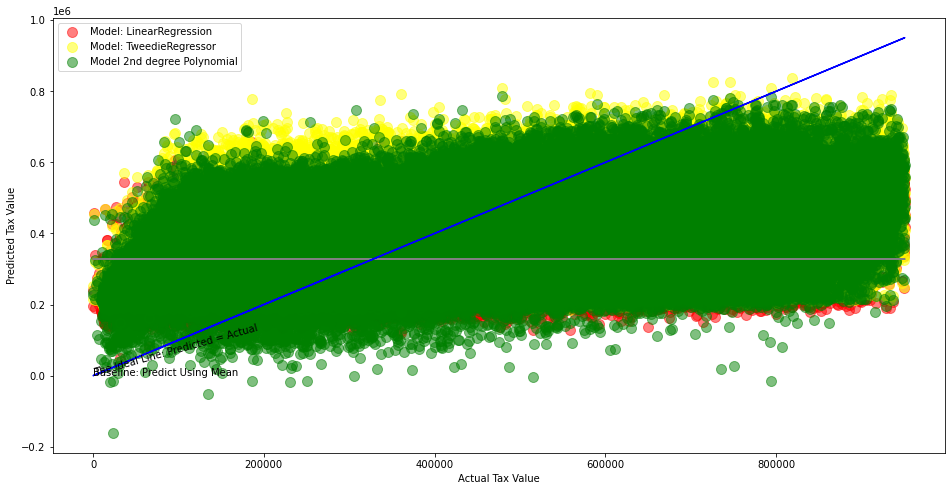

In [66]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (26, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=1, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Model Selection & Out-of-Sample Evaluation**

Model selected: lm (using LinearRegression)

In [62]:

y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  178978.9197342911


In [63]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,198987.478757,0.000000
1,OLS Regressor,178544.466377,0.192687
2,lasso_alpha_1,178566.575214,0.192487
3,glm_poisson,178603.016654,0.192158
4,quadratic,176546.675450,0.210652
